1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

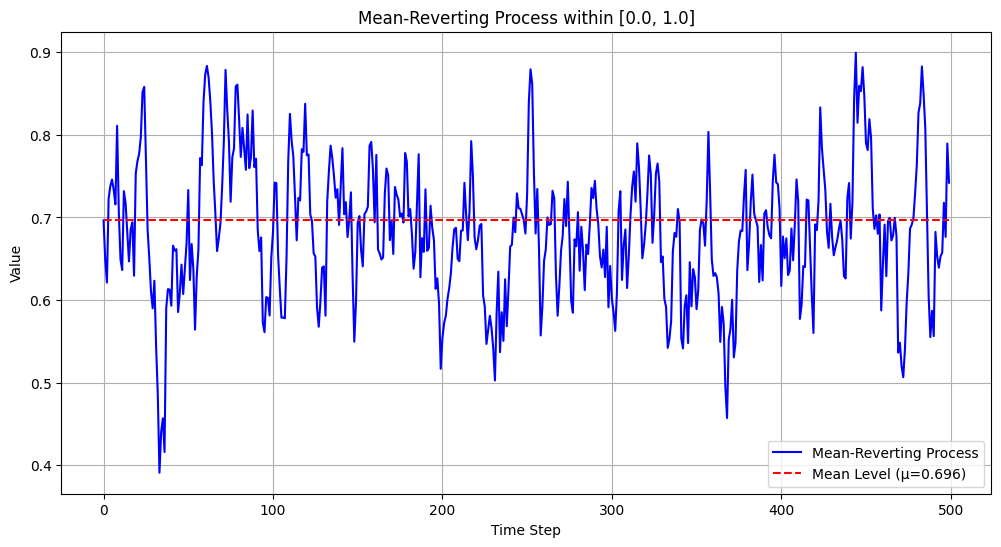

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def mean_reverting_process(a, b, num_steps=1000, k=0.1, sigma=0.05, seed=None):
    """
    Simulates a mean-reverting process within [a, b].

    Parameters:
    - a (float): Lower bound of the interval.
    - b (float): Upper bound of the interval.
    - num_steps (int): Number of time steps to simulate.
    - k (float): Speed of mean reversion.
    - sigma (float): Volatility parameter.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - path (np.ndarray): Simulated path of the process.
    - mu (float): Mean reversion level.
    """
    if seed is not None:
        np.random.seed(seed)

    mu = np.random.uniform(a, b)

    X = np.zeros(num_steps)
    X[0] = mu

    for t in range(1, num_steps):
        X_new = X[t-1] + k * (mu - X[t-1]) + sigma * np.random.randn()

        if X_new < a:
            X_new = a + (a - X_new)
        elif X_new > b:
            X_new = b - (X_new - b)

        X[t] = np.clip(X_new, a, b)

    return X, mu

a = 0.0
b = 1.0
num_steps = 500
k = 0.2
sigma = 0.05
seed = 123

path, mu = mean_reverting_process(a, b, num_steps, k, sigma, seed)

time = np.arange(num_steps)

plt.figure(figsize=(12, 6))
plt.plot(time, path, label='Mean-Reverting Process', color='blue')
plt.hlines(mu, xmin=0, xmax=num_steps-1, colors='red', linestyles='dashed', label=f'Mean Level (μ={mu:.3f})')
plt.title('Mean-Reverting Process within [{}, {}]'.format(a, b))
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

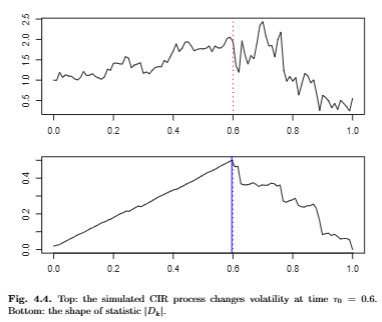

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

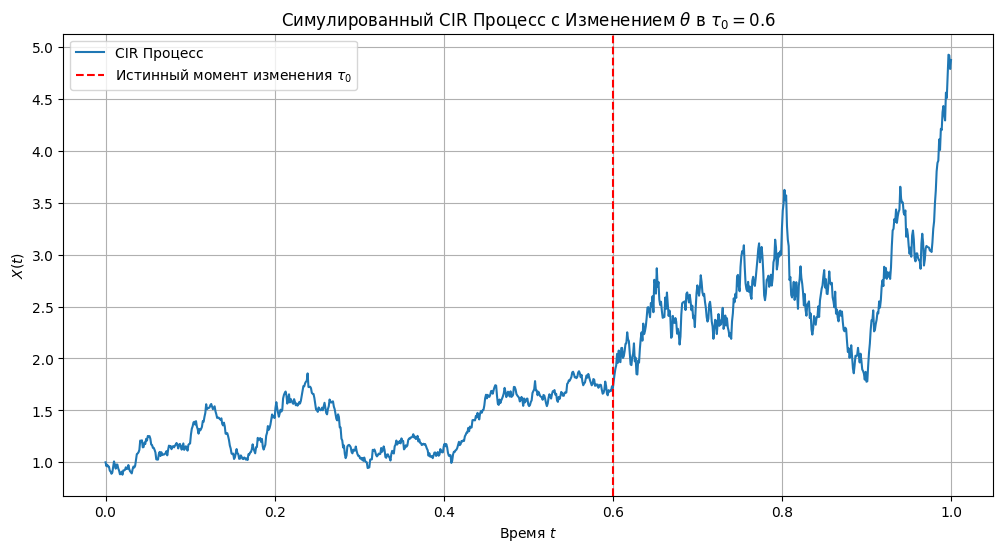

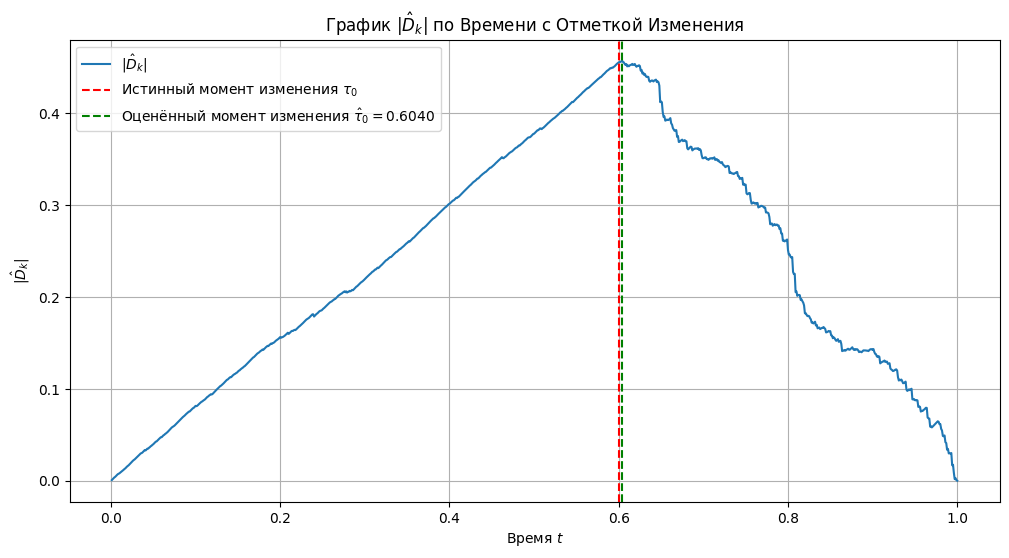

Истинный момент изменения: τ₀ = 0.6
Оценённый момент изменения: ŷ₀ = 0.6040


In [97]:
n = 1000
T = 1.0
Δt = T / n
t = np.linspace(0, T, n+1)
τ0 = 0.6
θ1 = 1.0
θ2 = 2.0

X = np.zeros(n+1)
X[0] = 1.0

ΔW = np.sqrt(Δt) * np.random.randn(n)

for i in range(n):
    θ = θ1 if t[i] < τ0 else θ2
    sqrt_Xi = np.sqrt(max(X[i], 0))
    X[i+1] = X[i] + (6 - 2 * X[i]) * Δt + θ * sqrt_Xi * ΔW[i]
    X[i+1] = max(X[i+1], 0)

plt.figure(figsize=(12, 6))
plt.plot(t, X, label='CIR Процесс')
plt.axvline(x=τ0, color='r', linestyle='--', label='Истинный момент изменения $\\tau_0$')
plt.xlabel('Время $t$')
plt.ylabel('$X(t)$')
plt.title('Симулированный CIR Процесс с Изменением $\\theta$ в $\\tau_0=0.6$')
plt.legend()
plt.grid(True)
plt.show()

Z = ((X[1:] - X[:-1]) - (6 - 2 * X[:-1]) * Δt) / np.sqrt(Δt)

Z_squared = Z**2
S_k = np.cumsum(Z_squared)
S_n = S_k[-1]

k_values = np.arange(1, n+1)
D_k = (S_k / S_n) - (k_values / n)

plt.figure(figsize=(12, 6))
plt.plot(t[1:], np.abs(D_k), label='$|\\hat{D}_k|$')
plt.axvline(x=τ0, color='r', linestyle='--', label='Истинный момент изменения $\\tau_0$')

k0 = np.argmax(np.abs(D_k))
t0_estimate = t[k0+1]

plt.axvline(x=t0_estimate, color='g', linestyle='--', label=f'Оценённый момент изменения $\\hat{{\\tau}}_0 = {t0_estimate:.4f}$')
plt.xlabel('Время $t$')
plt.ylabel('$|\\hat{D}_k|$')
plt.title('График $|\\hat{D}_k|$ по Времени с Отметкой Изменения')
plt.legend()
plt.grid(True)
plt.show()

print(f"Истинный момент изменения: τ₀ = {τ0}")
print(f"Оценённый момент изменения: ŷ₀ = {t0_estimate:.4f}")


3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

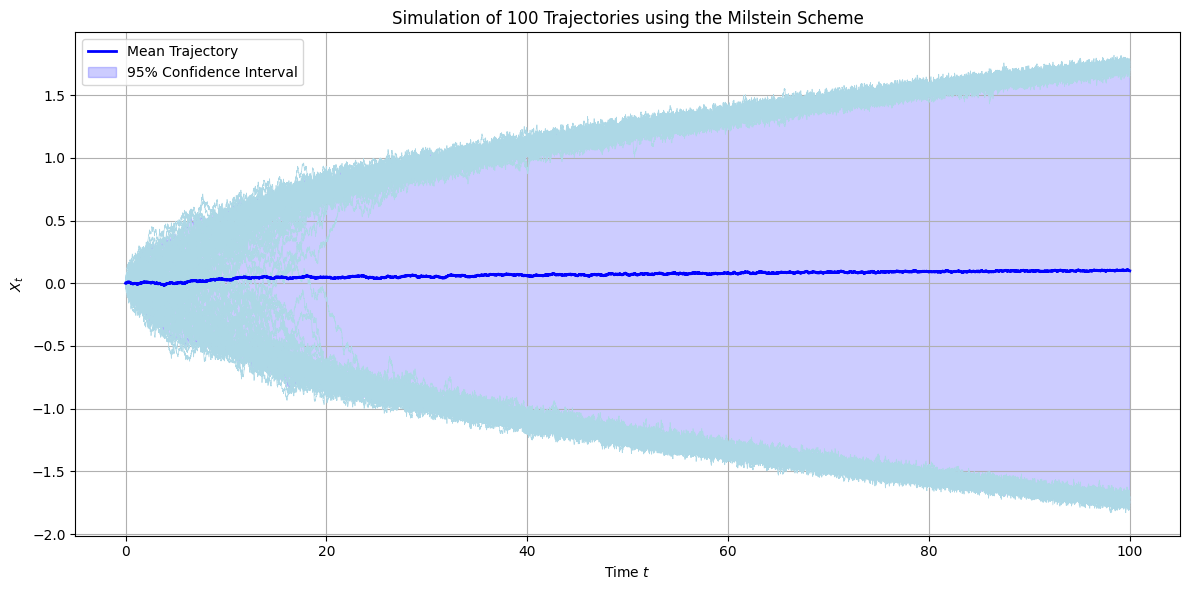

In [94]:
np.random.seed(42)


T = 100
dt = 0.01
N = int(T / dt)
t = np.linspace(0, T, N+1)
M = 100


def drift(t, X):
    return 0.03 * t * X - X**3

def diffusion(t, X):
    return 0.1

X = np.zeros((M, N+1))

for i in range(N):
    current_t = t[i]
    current_X = X[:, i]

    dW = np.random.normal(0, np.sqrt(dt), size=M)

    X[:, i+1] = current_X + drift(current_t, current_X) * dt + diffusion(current_t, current_X) * dW

mean_X = np.mean(X, axis=0)
lower_bound = np.percentile(X, 2.5, axis=0)
upper_bound = np.percentile(X, 97.5, axis=0)

plt.figure(figsize=(12, 6))

for m in range(M):
    plt.plot(t, X[m], color='lightblue', linewidth=0.5)

plt.plot(t, mean_X, color='blue', linewidth=2, label='Mean Trajectory')

plt.fill_between(t, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Time $t$')
plt.ylabel('$X_t$')
plt.title('Simulation of 100 Trajectories using the Milstein Scheme')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


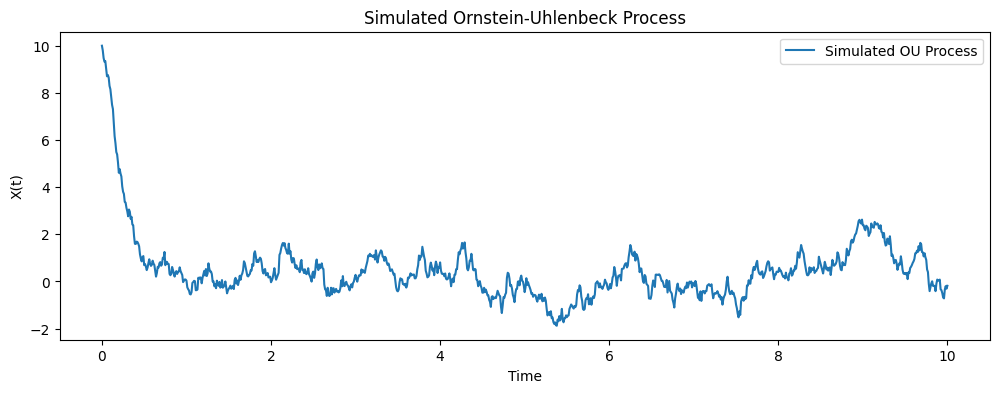

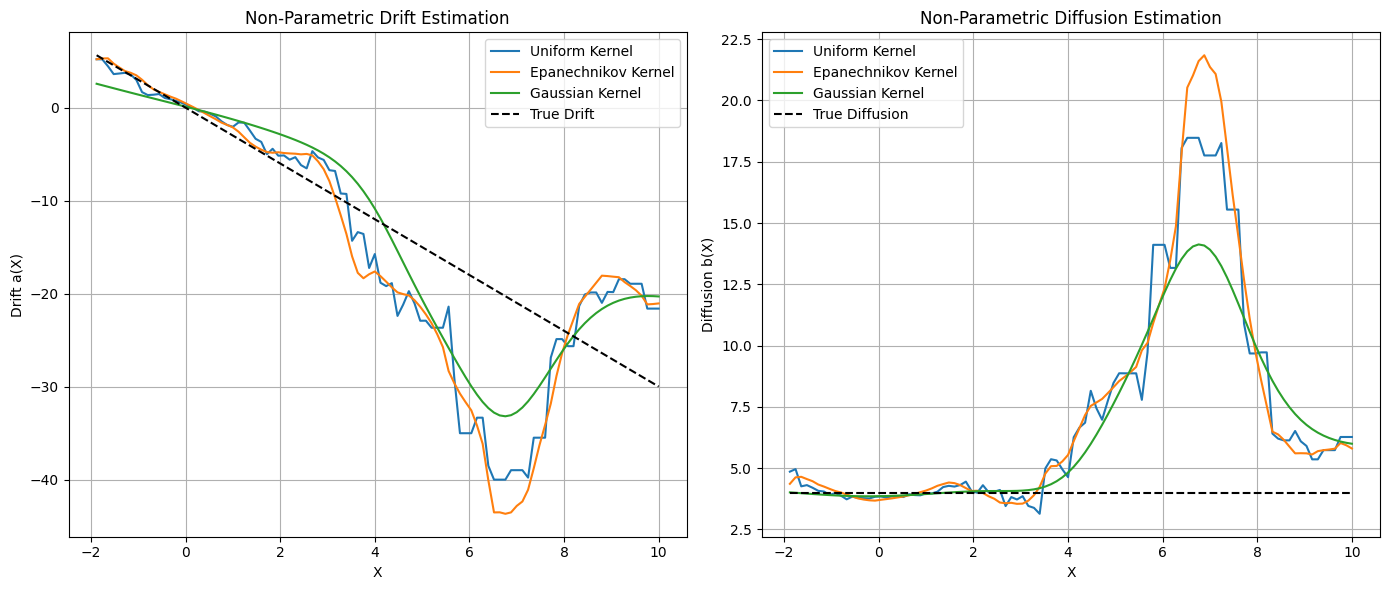

In [95]:
from scipy.stats import norm

np.random.seed(42)

theta1 = 0
theta2 = 3
theta3 = 2
X0 = 10

T = 10
dt = 0.01
N = int(T / dt)
time = np.linspace(0, T, N+1)

X = np.zeros(N+1)
X[0] = X0

for i in range(1, N+1):
    dW = np.sqrt(dt) * np.random.randn()
    X[i] = X[i-1] + (theta1 - theta2 * X[i-1]) * dt + theta3 * dW

plt.figure(figsize=(12, 4))
plt.plot(time, X, label='Simulated OU Process')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Simulated Ornstein-Uhlenbeck Process')
plt.legend()
plt.show()

def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return (0.75 * (1 - u**2)) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

delta_X = X[1:] - X[:-1]

h = 1.0

x_grid = np.linspace(np.min(X), np.max(X), 100)

def kernel_estimation(x_grid, X_prev, delta_X, kernel_func, h):
    a_est = np.zeros_like(x_grid)
    b_est = np.zeros_like(x_grid)
    for idx, x in enumerate(x_grid):
        u = (X_prev - x) / h
        weights = kernel_func(u)
        sum_weights = np.sum(weights)
        if sum_weights > 0:
            a_est[idx] = np.sum(weights * (delta_X / dt)) / sum_weights
            b_est[idx] = np.sum(weights * ((delta_X)**2 / dt)) / sum_weights
        else:
            a_est[idx] = np.nan
            b_est[idx] = np.nan
    return a_est, b_est

X_prev = X[:-1]

kernels = {
    'Uniform': uniform_kernel,
    'Epanechnikov': epanechnikov_kernel,
    'Gaussian': gaussian_kernel
}

a_true = -theta2 * x_grid
b_true = theta3**2 * np.ones_like(x_grid)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for name, kernel in kernels.items():
    a_est, b_est = kernel_estimation(x_grid, X_prev, delta_X, kernel, h)

    axes[0].plot(x_grid, a_est, label=f'{name} Kernel')

    axes[1].plot(x_grid, b_est, label=f'{name} Kernel')

axes[0].plot(x_grid, a_true, 'k--', label='True Drift')
axes[1].plot(x_grid, b_true, 'k--', label='True Diffusion')

axes[0].set_xlabel('X')
axes[0].set_ylabel('Drift a(X)')
axes[0].set_title('Non-Parametric Drift Estimation')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('X')
axes[1].set_ylabel('Diffusion b(X)')
axes[1].set_title('Non-Parametric Diffusion Estimation')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

Оцененные параметры CIR:
θ = 1.0
μ = 0.573192942258264
σ = 0.1
MSE Ornstein-Uhlenbeck: 0.0020356619571323016
MSE Geometric Brownian Motion: 0.010906365473796021
MSE Cox-Ingersoll-Ross: 0.006890244466613028


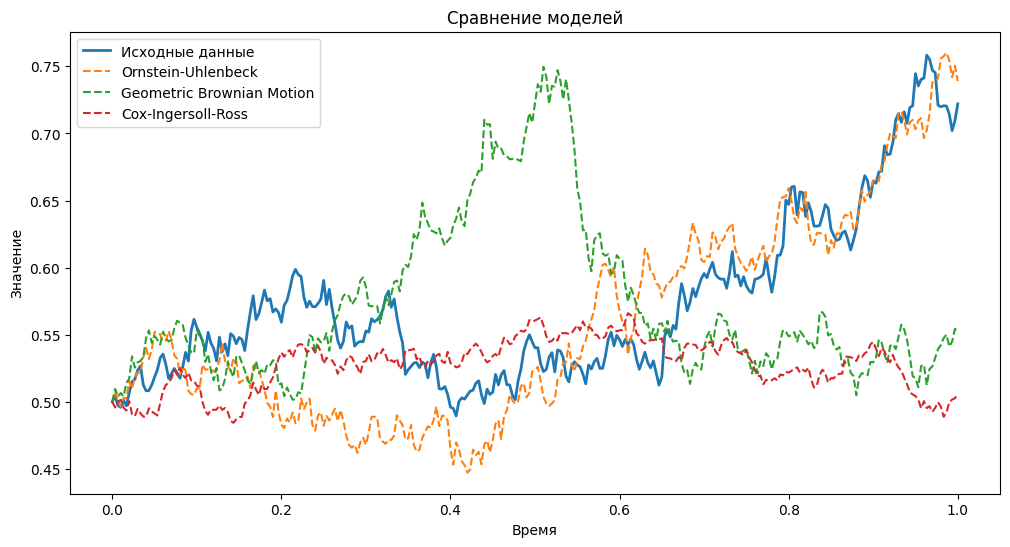

In [98]:
import pandas as pd
from scipy.optimize import minimize

df = pd.read_csv('/content/2.csv')
df.columns = ['Time', 'Value']
time = df['Time'].values
values = df['Value'].values
dt = np.diff(time)

def ou_log_likelihood(params, x, dt):
    theta, mu, sigma = params
    n = len(x) - 1
    likelihood = 0
    for i in range(n):
        m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
        s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
        likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
    return -likelihood

initial_guess = [1.0, np.mean(values), 0.1]

result_ou = minimize(ou_log_likelihood, initial_guess, args=(values, dt), bounds=((1e-5, None), (None, None), (1e-5, None)))
theta_ou, mu_ou, sigma_ou = result_ou.x

log_returns = np.diff(np.log(values))

mu_gbm = np.mean(log_returns) / np.mean(dt)
sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(dt))


def cir_method_of_moments(x, dt):
    X_t = x[:-1]
    X_tp = x[1:]
    mean_X_t = np.mean(X_t)
    mean_X_tp = np.mean(X_tp)
    var_X_tp = np.var(X_tp)

    def moments_error(params):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    initial_guess = [1.0, np.mean(values), 0.1]
    result = minimize(moments_error, initial_guess, bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
    if result.success:
        theta, mu, sigma = result.x
        return theta, mu, sigma
    else:
        raise RuntimeError("Оптимизация не сошлась для метода моментов.")

theta_cir, mu_cir, sigma_cir = cir_method_of_moments(values, dt)
print(f"Оцененные параметры CIR:\nθ = {theta_cir}\nμ = {mu_cir}\nσ = {sigma_cir}")

def simulate_cir(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
        variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
        x[i] = mean + np.sqrt(variance) * np.random.normal()
        x[i] = max(x[i], 0)
    return x

np.random.seed(123)
cir_sim = simulate_cir(theta_cir, mu_cir, sigma_cir, values[0], dt, len(values))

def simulate_ou(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
    return x

ou_sim = simulate_ou(theta_ou, mu_ou, sigma_ou, values[0], dt, len(values))

def simulate_gbm(mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
    return x

gbm_sim = simulate_gbm(mu_gbm, sigma_gbm, values[0], dt, len(values))

mse_ou = np.mean((values - ou_sim)**2)
mse_gbm = np.mean((values - gbm_sim)**2)
mse_cir = np.mean((values - cir_sim)**2)

print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
print(f"MSE Geometric Brownian Motion: {mse_gbm}")
print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

plt.figure(figsize=(12, 6))
plt.plot(time, values, label='Исходные данные', linewidth=2)
plt.plot(time, ou_sim, label='Ornstein-Uhlenbeck', linestyle='--')
plt.plot(time, gbm_sim, label='Geometric Brownian Motion', linestyle='--')
plt.plot(time, cir_sim, label='Cox-Ingersoll-Ross', linestyle='--')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Сравнение моделей')
plt.legend()
plt.show()
